# FIFA 19 Stats - Amazing Facts!

## Enjoy little interesting aspects of this FIFA 19 dataset through these wonderful visualizations...

#### This analysis is only for FIFA 19 and is not very suitable for real-world football. The reason being that there are many generated players and corresponding stats in this dataset...

# Data
## Let us load and preprocess our data for further applications...

In [1]:
import numpy as np
import pandas as pd

# For Visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import axes3d
plt.style.use('seaborn-dark')

from scipy.optimize import curve_fit

import os
import time
import gc
from operator import itemgetter as ig
from tqdm import tqdm_notebook
from collections import Counter
from collections import OrderedDict

In [2]:
def check_nulls(data,to_return=False):
    print("Total no. of players in dataset - ",data.shape[0])
    missing=list(pd.isnull(data).sum().items())
    missing=[x for x in missing if x[1]!=0]
    print("No. of columns containing missing values - ",len(missing))
    if(len(missing)==0):
        return
    missing=sorted(missing,key=lambda x:x[1],reverse=True)
    missing_20=missing[:20]
    missing_vals=list(map(ig(1),missing_20))
    missing_cols=list(map(ig(0),missing_20))
    sns.barplot(x=missing_vals,y=missing_cols)
    plt.title("Top Columns with missing values")
    plt.xlabel("No. of missing values")
    plt.ylabel("Columns")
    plt.show()
    if(to_return==True):
        return missing

In [3]:
player_data=pd.read_csv('../input/fifa19/data.csv')
print("Data Sample : ")
player_data.head()

Data Sample : 


,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


Total no. of players in dataset -  18207
No. of columns containing missing values -  76


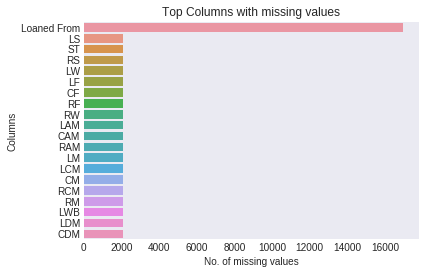

In [4]:
check_nulls(player_data)

In [5]:
def convert_value(sample):
    m_or_k=None
    if(sample.startswith('€')):
        sample=sample[1:]
    if(sample.endswith('M')):
        m_or_k='m'
    elif(sample.endswith('K')):
        m_or_k='k'
    if(m_or_k!=None):
        sample=sample[:-1]
    sample=float(sample)
    if(m_or_k=='k'):
        sample/=1000
    return sample

def convert_wage(sample):
    if(sample.endswith('K')):
        sample=sample[:-1]
    if(sample.startswith('€')):
        sample=sample[1:]
    sample=float(sample)
    return sample

In [6]:
positional_rating_cols=['LS','ST','RS','LW','LF','CF','RF','RW','LAM',
                        'CAM','RAM','LM','LCM','CM','RCM','RM','LWB','LDM',
                        'CDM','RDM','RWB','LB','LCB','CB','RCB','RB']

player_data['Value']=player_data['Value'].apply(convert_value)
player_data['Wage']=player_data['Wage'].apply(convert_wage)
player_data['Loaned From']=player_data['Loaned From'].fillna('Not on Loan')
player_data=player_data.drop(['Release Clause','Joined'],axis=1)

gk_data=player_data[player_data['Position']=='GK'].reset_index(drop=True)
gk_data=gk_data.drop(positional_rating_cols,axis=1)
data=player_data[player_data['Position']!='GK'].reset_index(drop=True)

missing=pd.isnull(data)
missing_vals=pd.Series(missing.sum(axis=1).values)
data=data.loc[missing_vals==0].reset_index(drop=True)

missing=pd.isnull(gk_data)
missing_vals=pd.Series(missing.sum(axis=1).values)
gk_data=gk_data.loc[missing_vals==0].reset_index(drop=True)

total_data=pd.concat([data,gk_data],sort=False,axis=0)
total_data=total_data[total_data['Value']!=0].reset_index(drop=True)

In [7]:
print("After preprocessing the data :\n\n")
print("Player Data :\n")
check_nulls(data)
print("\nGoalkeeper Data :\n")
check_nulls(gk_data)

After preprocessing the data :


Player Data :

Total no. of players in dataset -  15926
No. of columns containing missing values -  0

Goalkeeper Data :

Total no. of players in dataset -  1992
No. of columns containing missing values -  0


Our analysis will therefore be based on around 18000 players, including around 2000 goalkeepers...

# Country-Wise Analysis

## Worldwide Distribution of Players

### Let us analyze the distribution of football players across the world in FIFA 19...

In [8]:
from iso3166 import countries

world_filename='../input/shapefiles/ne_10m_admin_0_countries'
europe_filename='../input/shapefiles-europe/Europe'
southamerica_filename='../input/shapefiles-southamerica/South_America'

def plot_world_map(country_dict,filename,title="",alpha=3,dict_key='ADM0_A3',
                   num_bins=10,return_iso=False,not_iso=False,neg_vals=False,
                   x_scale1=0,x_scale2=1,y_scale1=0,y_scale2=1,min_zero=False):
    country_iso={}
    country_iso2={}
    for c in countries:
        country_iso[c.name]=c.alpha3
        country_iso2[c.name]=c.alpha2
    
    input_iso={}
    for c in country_dict:
        if(alpha==2):
            if(c in country_iso2):
                input_iso[country_iso2[c]]=country_dict[c]
        else:
            if(c in country_iso):
                input_iso[country_iso[c]]=country_dict[c]
    
    fig=plt.figure(figsize=(22, 12))
    ax=fig.add_subplot(111,facecolor='w',frame_on=False)
    ax.set_title(title,fontsize=30)
    m=Basemap(lon_0=0, projection='robin')
    m.drawmapboundary(color='gray')
    m.readshapefile(filename,'units')
    
    countries_used=set()
    for info,shape in zip(m.units_info,m.units):
        iso3=info[dict_key]
        if(not_iso==True):
            if(iso3 in country_map):
                iso3=country_map[iso3]
            if(iso3 in country_iso):
                iso3=country_iso[iso3]
        countries_used.add(iso3)
    
    iso_used=OrderedDict()
    for c in input_iso:
        if(c in countries_used):
            iso_used[c]=input_iso[c]
    data_vals=list(iso_used.values())
    iso_vals=list(iso_used.keys())
    
    cm=plt.get_cmap('plasma')
    scheme=[cm(i/num_bins) for i in range(num_bins)]
    if(neg_vals==False):
        bins=np.linspace(0,max(data_vals),num_bins)
    else:
        bins=np.linspace(min(data_vals),max(data_vals),num_bins)
    bin_list=np.digitize(data_vals,bins)-1
    iso_bins=OrderedDict(zip(iso_vals,bin_list))
    
    for info,shape in zip(m.units_info,m.units):
        iso3=info[dict_key]
        if(not_iso==True):
            if(iso3 in country_map):
                iso3=country_map[iso3]
            if(iso3 in country_iso):
                iso3=country_iso[iso3]
        if iso3 not in iso_bins:
            if(min_zero==True):
                color=scheme[0]
            else:
                color='w'
        else:
            color=scheme[iso_bins[iso3]]
        patches=[Polygon(np.array(shape),True)]
        pc=PatchCollection(patches)
        pc.set_facecolor(color)
        ax.add_collection(pc)
    
    ax.axhspan(0,1000*1800,facecolor='w',edgecolor='w',zorder=2)
    ax_legend=fig.add_axes([0.35,0.14,0.3,0.03],zorder=3)
    cmap=mpl.colors.ListedColormap(scheme)
    cb=mpl.colorbar.ColorbarBase(ax_legend,cmap=cmap,ticks=bins,boundaries=bins,orientation='horizontal')
    cb.ax.set_xticklabels([str(int(round(i,0))) for i in bins],rotation=45)
    x_lims=ax.get_xlim()
    ax.set_xlim(x_lims[1]*x_scale1,x_lims[1]*x_scale2)
    y_lims=ax.get_ylim()
    ax.set_ylim(y_lims[1]*y_scale1,y_lims[1]*y_scale2)
    plt.show()

In [9]:
country_map={
    'Antigua & Barbuda':'Antigua and Barbuda',
    'Bolivia':'Bolivia, Plurinational State of',
    'Bosnia Herzegovina':'Bosnia and Herzegovina',
    'Cape Verde':'Cabo Verde',
    'Central African Rep.':'Central African Republic',
    'China PR':'China',
    'Curacao':'Curaçao',
    'Czech Republic':'Czechia',
    'DR Congo':'Congo, Democratic Republic of the',
    'England':'United Kingdom of Great Britain and Northern Ireland',
    'FYR Macedonia':'North Macedonia',
    'Guinea Bissau':'Guinea-Bissau',
    'Iran':'Iran, Islamic Republic of',
    'Ivory Coast':"Côte d'Ivoire",
    'Korea DPR':"Korea, Democratic People's Republic of",
    'Korea Republic':'Korea, Republic of',
    'Moldova':'Moldova, Republic of',
    'Northern Ireland':'United Kingdom of Great Britain and Northern Ireland',
    'Palestine':'Palestine, State of',
    'Republic of Ireland':'Ireland',
    'Russia':'Russian Federation',
    'Scotland':'United Kingdom of Great Britain and Northern Ireland',
    'St Kitts Nevis':'Saint Kitts and Nevis',
    'St Lucia':'Saint Lucia',
    'Syria':'Syrian Arab Republic',
    'São Tomé & Príncipe':'Sao Tome and Principe',
    'Tanzania':'Tanzania, United Republic of',
    'Trinidad & Tobago':'Trinidad and Tobago',
    'United States':'United States of America',
    'Venezuela':'Venezuela, Bolivarian Republic of',
    'Wales':'United Kingdom of Great Britain and Northern Ireland',
    'Gibraltar (UK)':'United Kingdom of Great Britain and Northern Ireland',
    'Guernsey (UK)':'United Kingdom of Great Britain and Northern Ireland',
    'Isle of Man (UK)':'United Kingdom of Great Britain and Northern Ireland',
    'Jersey (UK)':'United Kingdom of Great Britain and Northern Ireland',
    'Macedonia':'North Macedonia',
    'United Kingdom':'United Kingdom of Great Britain and Northern Ireland',
    'Faeroe Islands (Denmark)':'Denmark',
    'Jan Mayen (Norway)':'Norway',
    'Svalbard (Norway)':'Norway'
}
total_data['Nationality']=pd.Series([x if x not in country_map else country_map[x] for x in total_data['Nationality']])

In [10]:
total_nationality=total_data.groupby('Nationality')['Name'].aggregate('count')
total_nationality=total_nationality.to_dict()

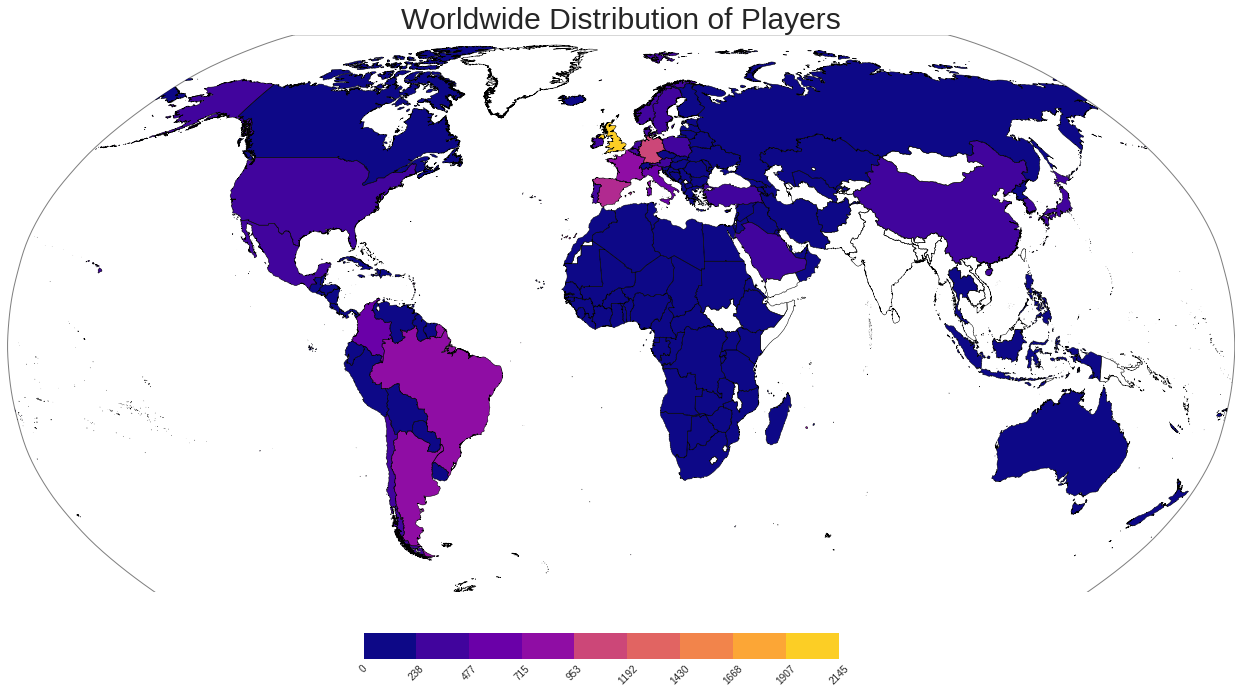

In [11]:
plot_world_map(total_nationality,world_filename,
               title="Worldwide Distribution of Players",
               alpha=3,num_bins=10)

We see only one speck of yellow in the world map - the United Kingdom. The reason United Kingdom has been represented by so many players is that FIFA 19 has 4 English leagues and 1 Scottish league, which obviously will result in many English players being present in the FIFA 19 dataset.

The presence of football leagues  in FIFA 19 of countries like China, Saudi Arabia, Japan, Colombia, Poland, Chile, Sweden, Norway and Turkey ensures decent representation of the mentioned countries as well.

## Average Overall Rating - Country-Wise

### We shall now move onto analyzing which countries have players with high average overall rating. We shall use 'Player Overall Rating' and 'Player Rating' interchangeably...

In [12]:
avg_player_per_country=int(np.round(np.mean(list(total_nationality.values()))))
print("Average No. of Players Representing a Country = ",avg_player_per_country)
print("\nCountries having representation lesser than {thresh} will not be considered for average overall rating...".format(thresh=avg_player_per_country))

Average No. of Players Representing a Country =  112

Countries having representation lesser than 112 will not be considered for average overall rating...


In [13]:
def get_avg_country_val(col,total_val):
    sum_val_countries=total_data.groupby('Nationality')[col].aggregate('sum')
    total_sum_val_countries=sum_val_countries.to_dict()
    
    avg_val_nationality={}
    for c in total_sum_val_countries:
        if(c in total_nationality):
            if(total_nationality[c]>=avg_player_per_country):
                avg_val_nationality[c]=total_sum_val_countries[c]/total_nationality[c]
            else:
                avg_val_nationality[c]=0
    return avg_val_nationality

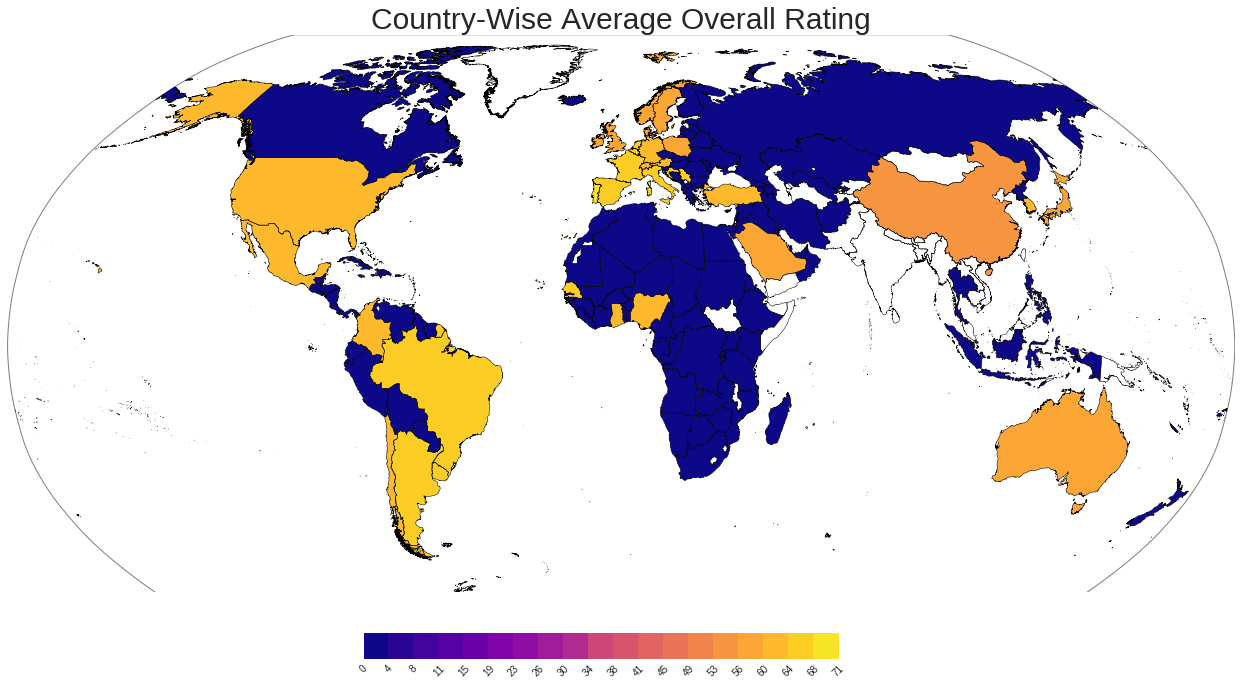

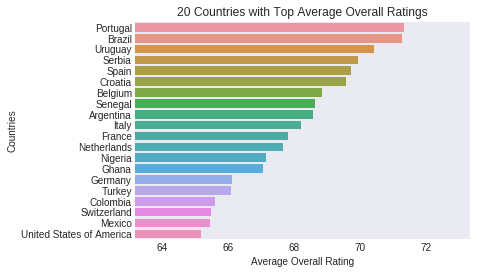

In [14]:
avg_rating_nationality=get_avg_country_val('Overall',total_data)

plot_world_map(avg_rating_nationality,world_filename,
               title="Country-Wise Average Overall Rating",
               alpha=3,num_bins=20)

top_avg_ratings=sorted(avg_rating_nationality.items(),key=lambda x:x[1],reverse=True)[:20]
top_avg_ratings_countries=list(map(ig(0),top_avg_ratings))
top_avg_ratings_vals=list(map(ig(1),top_avg_ratings))
sns.barplot(x=top_avg_ratings_vals,y=top_avg_ratings_countries)
plt.title("20 Countries with Top Average Overall Ratings")
plt.xlabel("Average Overall Rating")
plt.ylabel("Countries")
plt.xlim(min(top_avg_ratings_vals)-2,max(top_avg_ratings_vals)+2)
plt.show()

We see some really interesting observations here. Asian countries and Australia seem to have lesser average overall ratings. African countries, though poorly represented, have a good average overall rating with 3 African countries among the Top 20 countries.

Portugal and Brazil emerge as close winners. It is also interesting to observe that many of the top 20 countries do not have a very good representation (eg. Portugal, Uruguay etc.) while the United Kingdom, which has maximum representation, does not even appear in the top 20 countries. This might be happening because the lower-tier leagues in UK might be bringing the overall average rating down. On the other hand, most other countries have only their top football league in FIFA 19.

For example, if FIFA 19 would include Portugal's second tier league along with Liga NOS (the top-tier Portuguese league), then the average overall rating of Portugal would probably go down, while if FIFA 19 considered 'only' the Premier League in UK and not the lower-tier leagues, then the average overall rating of UK would be significantly higher.

### Europe & South America

Given that Europe and South America are considered Football Powerhouses, let us analyze the average overall ratings of European and South American countries...

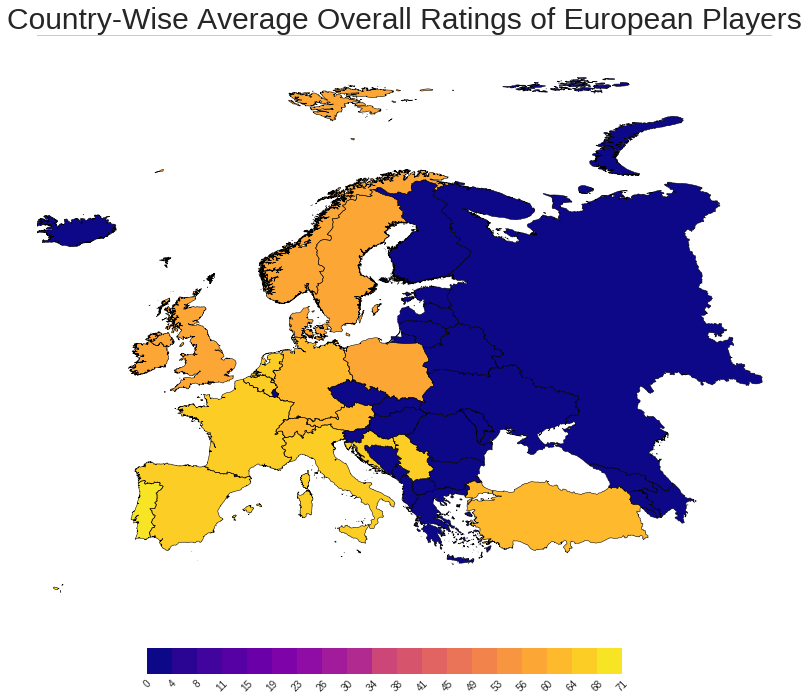

In [15]:
plot_world_map(avg_rating_nationality,europe_filename,
               title="Country-Wise Average Overall Ratings of European Players",
               alpha=3,dict_key='NAME',num_bins=20,not_iso=True,
               x_scale1=0.45,x_scale2=0.65,y_scale1=0.65,y_scale2=1)

Scandinavian countries have a poor average overall rating while countries like Turkey, Croatia and Serbia impress with surprisingly good average overall ratings. European giants like Spain, Germany, Italy and France also have a great average overall rating, despite their top two leagues being present in FIFA 19. UK's surprising low average rating may be, as described, because of five of its leagues being present in FIFA 19.

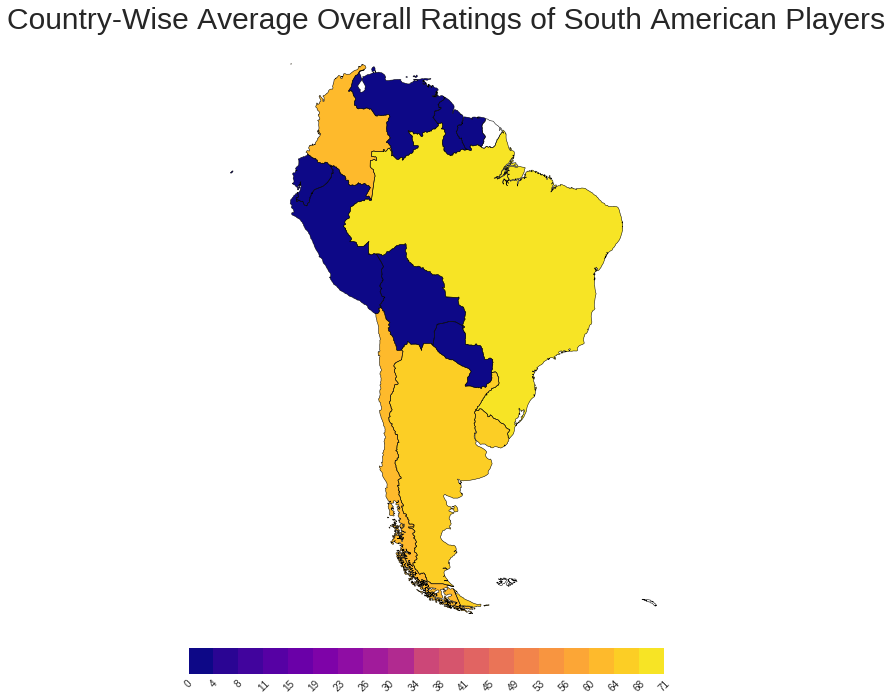

In [16]:
plot_world_map(avg_rating_nationality,southamerica_filename,
               title="Country-Wise Average Overall Ratings of South American Players",
               dict_key='COUNTRY',alpha=3,num_bins=20,not_iso=True,
               x_scale1=0.25,x_scale2=0.42,y_scale1=0.1,y_scale2=0.6)

It is important to note that Brazillian clubs actually have made-up players in FIFA 19. Thus, any kind of analysis on them might or might not reflect in the real-world scenario.

## Country-Wise Average Player Value

### Let us check would there be any significant difference between average overall rating and average player value of countries...

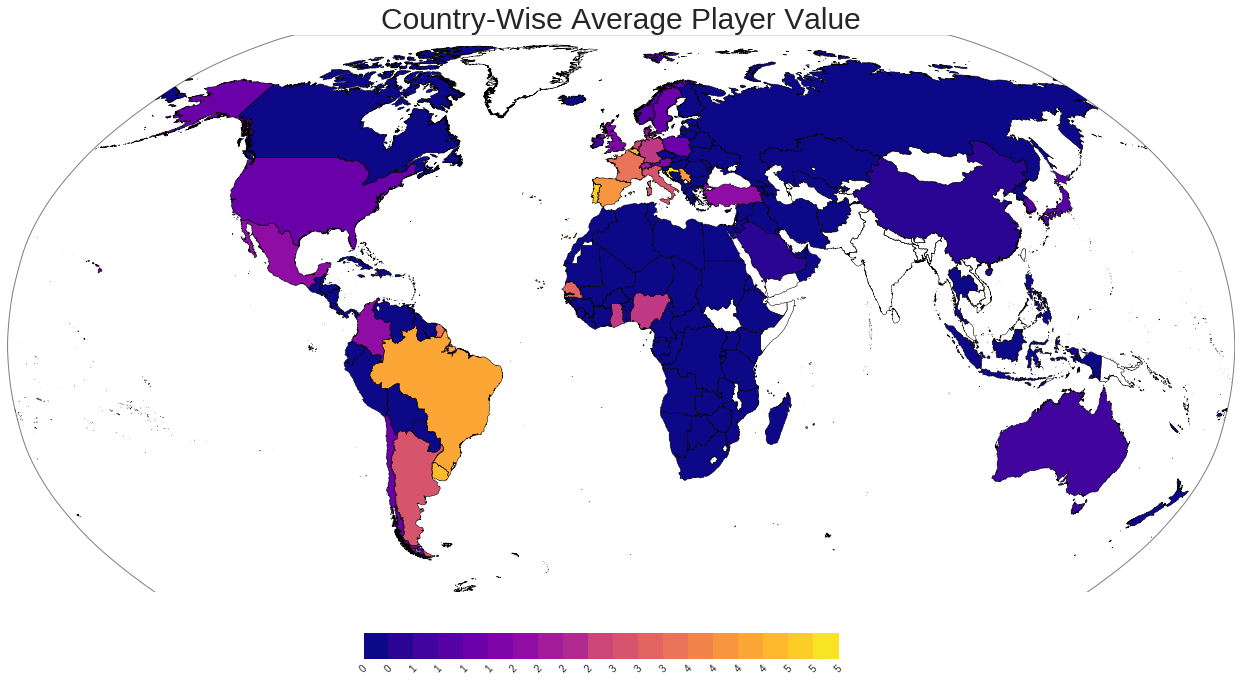

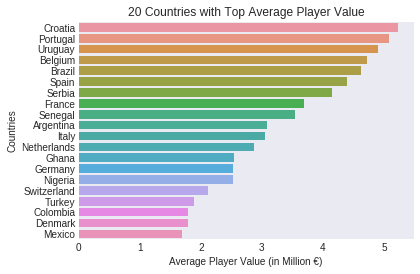

In [17]:
avg_value_nationality=get_avg_country_val('Value',total_data)

plot_world_map(avg_value_nationality,world_filename,
               title="Country-Wise Average Player Value",
               alpha=3,num_bins=20)

top_avg_value=sorted(avg_value_nationality.items(),key=lambda x:x[1],reverse=True)[:20]
top_avg_value_countries=list(map(ig(0),top_avg_value))
top_avg_value_vals=list(map(ig(1),top_avg_value))
sns.barplot(x=top_avg_value_vals,y=top_avg_value_countries)
plt.title("20 Countries with Top Average Player Value")
plt.xlabel("Average Player Value (in Million €)")
plt.ylabel("Countries")
plt.show()

There doesn't seem to be much of a change between country-wise average overall rating and player value. Most of the top 20 countries with best average player values are also in the top 20 countries with best average overall rating. This represents justified value for money!

### Value For Money

We know try to figure out a pattern between player ratings and player value. We can, indeed, approximate the relation between ratings and values through an exponential curve. Using curve fitting, we find out the exact parameters and compare the available data and resulting curve...

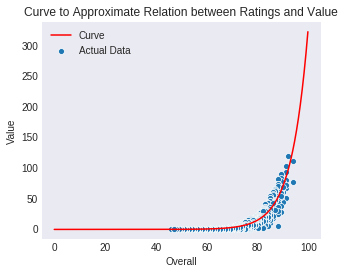

In [18]:
e=np.e
def func(x,a,b,c,d):
    return a*e**(b*(x-c))-d

# Curve Fitting
opt,cov=curve_fit(f=func,xdata=total_data['Overall'],ydata=total_data['Value'])

fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.scatterplot(x=total_data['Overall'],y=total_data['Value'],ax=ax,label='Actual Data')
x=np.arange(0,100,0.25)
ax.plot(x,[func(val,a=opt[0],b=opt[1],c=opt[2],d=opt[3]) for val in x],color='red',label='Curve')
ax.set_title("Curve to Approximate Relation between Ratings and Value")
ax.legend(loc='best')
plt.show()

Therefore, using this curve as our 'Actual Player Value', we can find out by how much more or less money has a player been valued. This represents value for money; a player with value less than actual value represents good value for money, while a player with value more than actual value represents bad value for money...

In [19]:
value_for_money=[]
for ind,row in total_data.iterrows():
    value=row['Value']
    ideal_value=func(row['Overall'],a=opt[0],b=opt[1],c=opt[2],d=opt[3])
    error=(ideal_value-value)*1000 # Error in k€
    value_for_money.append(error)
total_data=total_data.assign(Value_for_Money=value_for_money)

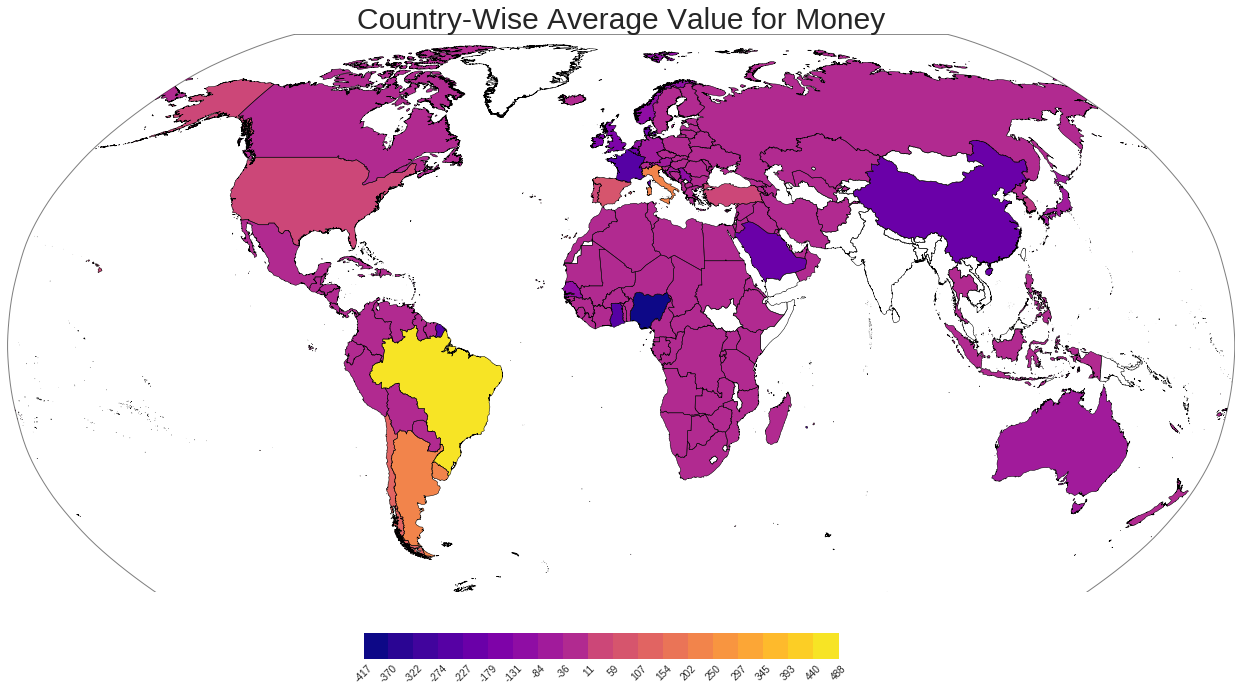

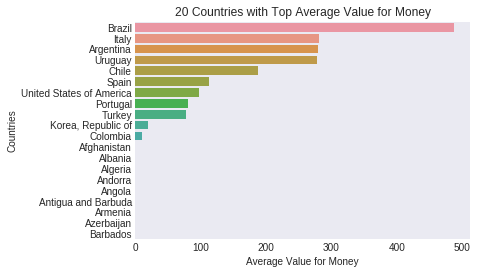

In [20]:
avg_vfm_nationality=get_avg_country_val('Value_for_Money',total_data)

plot_world_map(avg_vfm_nationality,world_filename,
               title="Country-Wise Average Value for Money",
               alpha=3,num_bins=20,neg_vals=True,min_zero=False)

top_avg_vfm=sorted(avg_vfm_nationality.items(),key=lambda x:x[1],reverse=True)[:20]
top_avg_vfm_countries=list(map(ig(0),top_avg_vfm))
top_avg_vfm_vals=list(map(ig(1),top_avg_vfm))
sns.barplot(x=top_avg_vfm_vals,y=top_avg_vfm_countries)
plt.title("20 Countries with Top Average Value for Money")
plt.xlabel("Average Value for Money")
plt.ylabel("Countries")
plt.show()

Brazillians steal the show with an incredibly high value for money. Again, the players in Brazillian clubs are made-up. However, the good thing about these players is that they have a high average player rating and terrific value for money. So you might not hesitate spending big bucks in FIFA 19 for a Brazillian player, for there is a high chance he'll be worth the money.

Also, there are only a handful of countries offering positive value for money, while the others offer negative value for money. So there is obviously severe over-pricing going on...

# Club Analysis

### Let us analyze average player age of the clubs...

In [21]:
print("No. of Clubs - ",total_data['Club'].nunique())

No. of Clubs -  651


In [22]:
def plot_club_stats(col,title,total_data=total_data,space=4,main_col='Club'):
    club_val=total_data.groupby([main_col])[col].aggregate('mean')
    low_club_val=club_val.sort_values()[:10]
    high_club_val=club_val.sort_values(ascending=False)[:10]

    avg_club_val=np.mean(total_data[col])
    q1_club_val=np.quantile(total_data[col],0.25)
    q3_club_val=np.quantile(total_data[col],0.75)

    fig,ax=plt.subplots(1,1,figsize=(16,8))
    x1_labels=list(low_club_val.keys())
    x1=np.arange(len(x1_labels))
    y1=list(low_club_val.values)
    x2_labels=list(high_club_val.keys())
    x2=np.arange(len(x2_labels))
    y2=list(high_club_val.values)

    sns.pointplot(x=x1,y=y1,ax=ax,color='red')
    for ind,(x,y) in enumerate(zip(x1,y1)):
        ax.annotate(
            x1_labels[ind],(x,y),(x,y),rotation=45,
            bbox=dict(boxstyle="round",fc='w'),va='center',ha='center',fontsize=15)
    sns.pointplot(x=x2,y=y2,ax=ax,color='blue')
    for ind,(x,y) in enumerate(zip(x2,y2)):
        ax.annotate(
            x2_labels[ind],(x,y),(x,y),rotation=45,
            bbox=dict(boxstyle="round",fc='w'),va='center',ha='center',fontsize=15)

    ax.axhline(avg_club_val)
    ax.annotate("Mean",(-1,avg_club_val),fontsize=15,va='bottom',ha='center')
    ax.axhline(q1_club_val)
    ax.annotate("25% Percentile",(-1,q1_club_val),fontsize=15,va='bottom',ha='center')
    ax.axhline(q3_club_val)
    ax.annotate("75% Percentile",(-1,q3_club_val),fontsize=15,va='bottom',ha='center')

    plt.title("Teams with Highest & Lowest Average "+title,fontsize=20)
    plt.ylabel("Average "+title,fontsize=15)
    plt.ylim(min(y1)-space,max(y2)+space)
    plt.xlim(-2,len(x1)-0.5)
    ax.set_xticklabels('')
    plt.show()

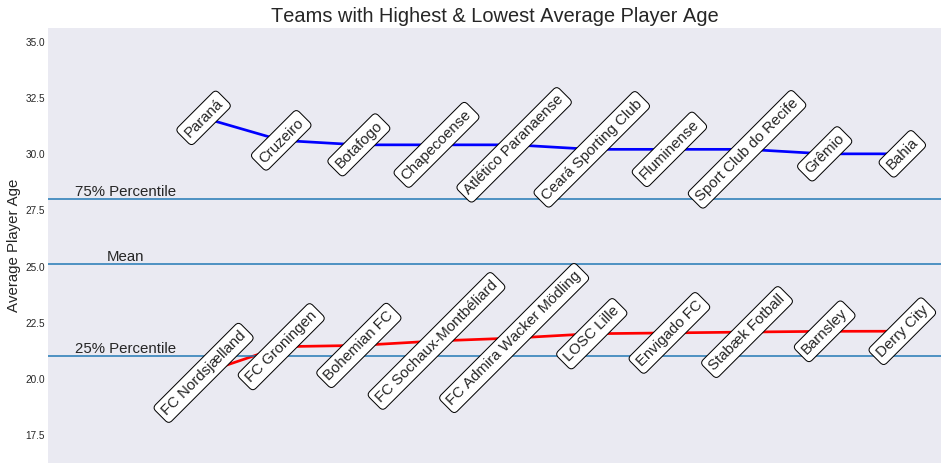

In [23]:
plot_club_stats('Age','Player Age')

It is interesting to observe that 9 out of the top 10 teams that have highest average player age are from Brazil. Coincidence?

Actually, as mentioned, Brazillian clubs have made-up players in FIFA 19. So it just might be that made-up players innately have a higher average age. So if you are indeed interested in purchasing a player from a Brazillian club in FIFA 19, be aware that the player is made-up and that there is low chance of him being young.

### Let us now analyze average player rating, player potential and value for money of the clubs...

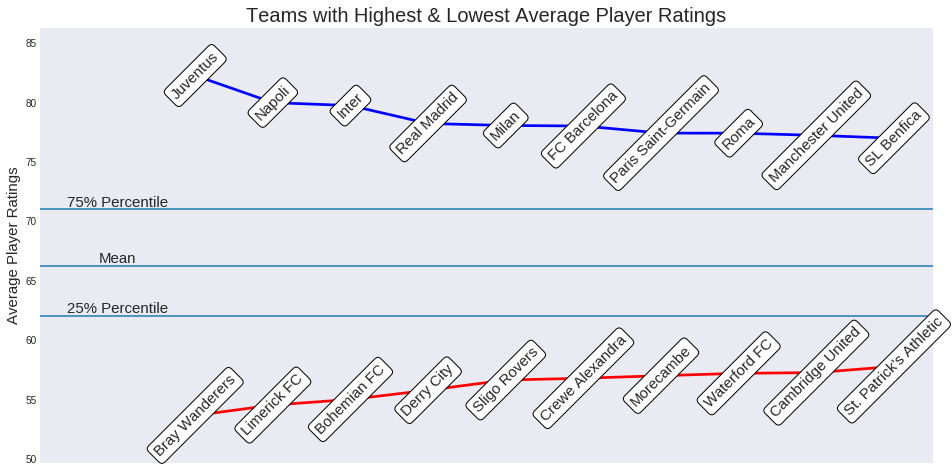

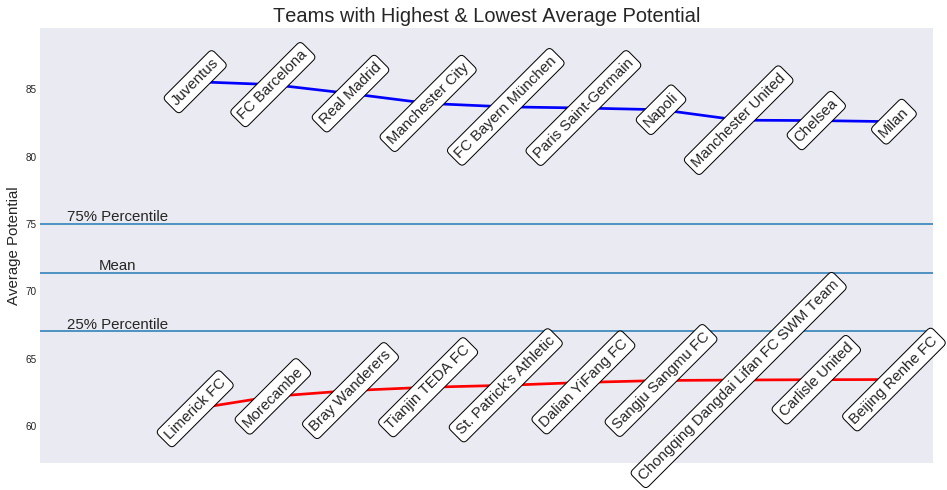

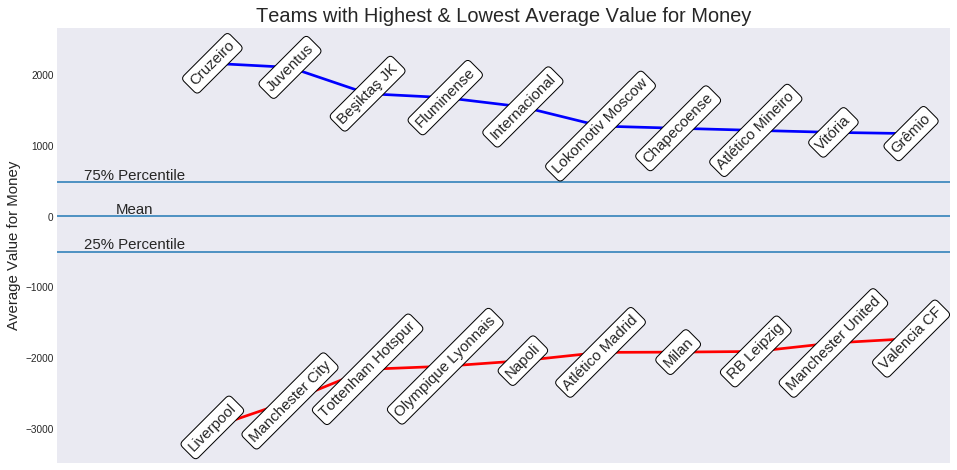

In [24]:
plot_club_stats('Overall','Player Ratings')
plot_club_stats('Potential','Potential')
plot_club_stats('Value_for_Money','Value for Money',space=500)

Juventus has a supreme average player rating over other teams. It is also surprising to see 5 Italian teams out of the top 10 teams with highest average ratings. Also all 10 teams with lowest average player rating are either from Ireland or UK, with as many as 7 out of them being Irish. Disappointing stats for Irish Football...

Teams like Manchester City, Chelsea and Bayern Munich, which were surprise absentees for teams with highest average player ratings, seem to have a very good potential moving forward. Juventus still remains first, but this time with a narrower lead. Also, some of the Irish teams have moved out of the list of teams with lowest potential to make space for some Asian teams...

The Top 10 teams with highest average value for money consist of almost 5 Brazillian teams, again showcasing how worthwhile it might be to buy players from Brazil. Juventus seems to be the only European Giant with a great positive value for money. Football powerhouses like Liverpool, Manchester City, Manchester United and Athletico Madrid find themselves with many overpriced players, again indicating the crazy level of over-pricing that happens among big teams...

# Player Analysis

## Growth

### We have defined Growth as the difference between his Potential Rating & Overall Rating. Growth of a player might also be affected by his age, right? Let us check this dependency and also others...

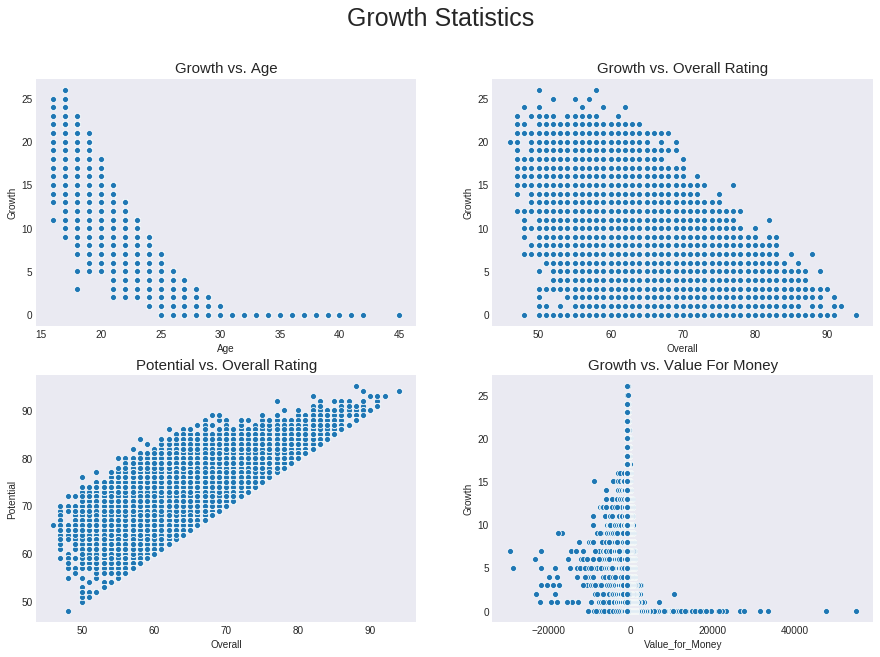

In [25]:
total_data['Growth']=total_data['Potential']-total_data['Overall']

fig,ax=plt.subplots(2,2,figsize=(15,10))
fig.suptitle("Growth Statistics",fontsize=25)
sns.scatterplot(total_data['Age'],total_data['Growth'],ax=ax[0,0])
ax[0,0].set_title("Growth vs. Age",fontsize=15)
sns.scatterplot(total_data['Overall'],total_data['Growth'],ax=ax[0,1])
ax[0,1].set_title("Growth vs. Overall Rating",fontsize=15)
sns.scatterplot(total_data['Overall'],total_data['Potential'],ax=ax[1,0])
ax[1,0].set_title("Potential vs. Overall Rating",fontsize=15)
sns.scatterplot(total_data['Value_for_Money'],total_data['Growth'],ax=ax[1,1])
ax[1,1].set_title("Growth vs. Value For Money",fontsize=15)
plt.show()

Important Observations :
* We see here that there is no player below 25 who is expected to have zero growth while no player above 30 is expected to have any kind of growth
* Players with lower overall rating can expect to have higher growth, though the trend is not definite and reliable
* No player has potential rating lower than overall rating, indicating no expected loss of quality for any player
* Players with high growth expectancy are having either moderate value for money or negative value for money. Thus, players with good growth are often valued close to or above their ideal value. But if the player does indeed fulfill his potential, it'll be a good investment in the long run

### Players with Highest Expected Growth

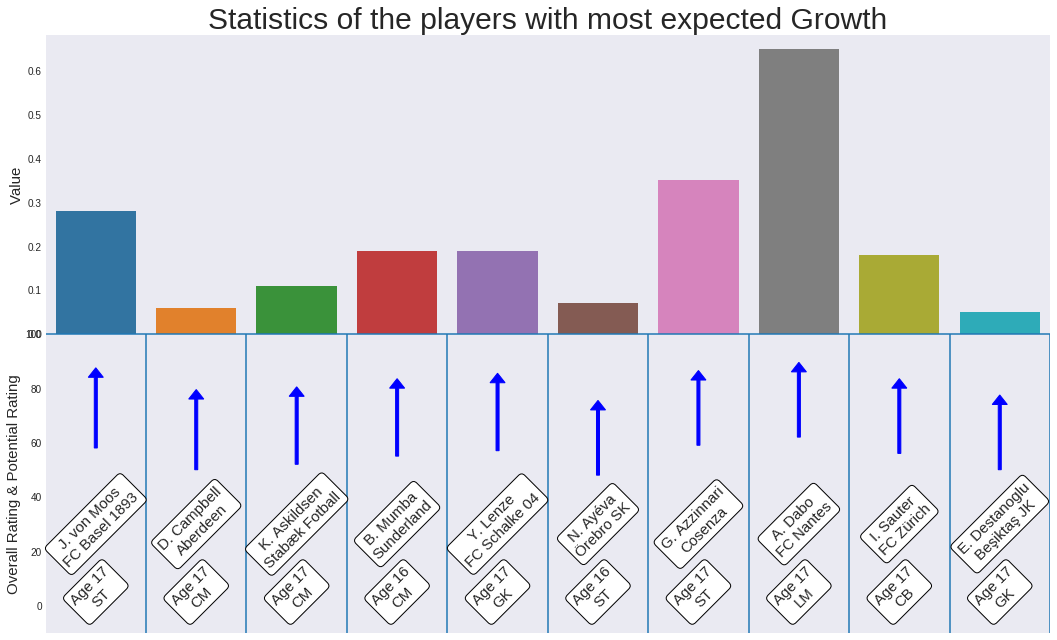

In [26]:
top_growers=total_data.sort_values('Growth',ascending=False)[['Name','Club','Age','Overall','Growth','Value','Position','Nationality']].reset_index(drop=True).head(10)
fig,ax=plt.subplots(2,1,sharex=True,figsize=(18,11))
ax[0].set_title("Statistics of the players with most expected Growth",fontsize=30)
fig.subplots_adjust(hspace=0)
x=np.arange(top_growers.shape[0])
sns.barplot(x=x,y=top_growers['Value'],ax=ax[0])
ax[0].axhline(0)
ax[0].set_ylabel("Value",fontsize=15)
ax[1].axhline(100)
for index,player in top_growers.iterrows():
    ax[1].arrow(index,player['Overall'],0,player['Growth'],color='blue',
              width=0.03,head_width=0.15,head_length=3.5)
    ax[1].annotate(player['Name']+'\n'+player['Club'],(index,30),ha='center',va='center',rotation=45,
               bbox=dict(boxstyle='round',fc='white'),fontsize=15)
    ax[1].annotate('Age '+str(player['Age'])+'\n'+player['Position'],(index,5),ha='center',va='center',rotation=45,
               bbox=dict(boxstyle='round',fc='white'),fontsize=15)
    ax[1].axvline(index+0.5)
ax[1].set_ylim(-10,100)
ax[1].set_ylabel("Overall Rating & Potential Rating",fontsize=15)
plt.xticks(x,"")
plt.show()

The players with highest expected growth are actually not very famous. These players are extremely young, do not have a good overall rating, but are predicted to reach potential ratings of around 75-80. This is great, but any club that buys any of these players must have patience while the player progresses. As shown previously, the rating that a player possesses once he is 25 gives you a good idea of the maximum rating he can ever possess, while if a player crosses 30, it is improbable that the player will develop further.

## Position Analysis

### To simplify our analysis, we'll categorize all footballing positions to 11 general positions - 
* GK (GoalKeeper)
* CB, LB, RB (Defenders)
* CM, DM, LM, RM (Midfielders)
* CF, LF, RF (Forwards)

In [27]:
position_map={
    'RF':'RF',
    'ST':'CF',
    'LW':'LF',
    'RCM':'RM',
    'LF':'LF',
    'RS':'RF',
    'RCB':'CB',
    'LCM':'LM',
    'CB':'CB',
    'LDM':'DM',
    'CAM':'CM',
    'CDM':'DM',
    'LS':'LF',
    'LCB':'CB',
    'RM':'RM',
    'LAM':'LM',
    'LM':'LM',
    'LB':'LB',
    'RDM':'DM',
    'RW':'RF',
    'CM':'CM',
    'RB':'RB',
    'RAM':'RM',
    'CF':'CF',
    'RWB':'RB',
    'LWB':'LB',
    'GK':'GK'
}
total_data=total_data.assign(General_Positions=total_data['Position'].map(position_map))
positions=['GK','CB','LB','RB','DM','CM','LM','RM','CF','LF','RF']

### Position Stats

In [28]:
foot_count=total_data.groupby('Preferred Foot')['Name'].aggregate('count')
right=foot_count['Right']
left=foot_count['Left']
ratio=right/left
print("Preferred Foot Count:\n")
print("Right - ",right)
print("Left - ",left)
print("\nNatural Right-Footed to Left-Footed Ratio :\nR:L = {r}:{l} = {ratio:.2f}".format(r=right,l=left,ratio=ratio))

Preferred Foot Count:

Right -  13748
Left -  4159

Natural Right-Footed to Left-Footed Ratio :
R:L = 13748:4159 = 3.31


In [29]:
position_best_foot={}
position_foot=total_data.groupby(['General_Positions','Preferred Foot'])['Name'].aggregate('count')
for pos in positions:
    position_best_foot[pos]={}
    l=position_foot[pos]['Left']*ratio
    r=position_foot[pos]['Right']
    if(r>=l):
        position_best_foot[pos]['Best']='Right'
        position_best_foot[pos]['Perc']=r*100/(l+r)
    else:
        position_best_foot[pos]['Best']='Left'
        position_best_foot[pos]['Perc']=l*100/(l+r)
        
position_rating=total_data.groupby('General_Positions')['Overall'].aggregate('mean')
position_rating=position_rating.to_dict()

position_age=total_data.groupby('General_Positions')['Age'].aggregate('mean')
position_age=position_age.to_dict()

position_value=total_data.groupby('General_Positions')['Value'].aggregate('mean')
position_value=position_value.to_dict()

mid_x=285
mid_y=408
position_loc={
    'GK':[[mid_x,mid_y*12/7],'yellow'],
    'RB':[[mid_x*6/4,mid_y*10/7],'cyan'],
    'LB':[[mid_x*2/4,mid_y*10/7],'cyan'],
    'CB':[[mid_x,mid_y*10/7],'cyan'],
    'DM':[[mid_x,mid_y*8/7],'lime'],
    'RM':[[mid_x*6/4,mid_y*6/7],'lime'],
    'LM':[[mid_x*2/4,mid_y*6/7],'lime'],
    'CM':[[mid_x,mid_y*4/7],'lime'],
    'RF':[[mid_x*6/4,mid_y*2/7],'tomato'],
    'LF':[[mid_x*2/4,mid_y*2/7],'tomato'],
    'CF':[[mid_x,mid_y*2/7],'tomato']
}

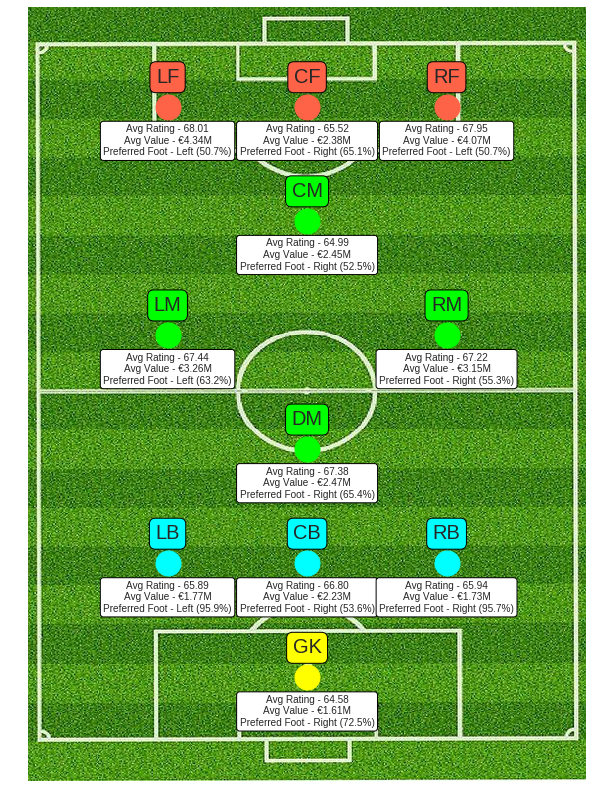

In [30]:
fig,ax=plt.subplots(1,1,figsize=(10,20))
pitch_img=plt.imread('../input/football-pitch/Football Pitch.jpg')
ax.imshow(pitch_img)
for pos in positions:
    loc=position_loc[pos][0]
    color=position_loc[pos][1]
    ax.plot(loc[0],loc[1],'o',color=color,markersize=25)
    rating=position_rating[pos]
    age=position_age[pos]
    value=position_value[pos]
    foot=position_best_foot[pos]['Best']
    foot_perc=position_best_foot[pos]['Perc']
    ax.annotate(pos,(loc[0],loc[1]-30),fontsize=20,va='center',ha='center',
                bbox=dict(boxstyle='round',fc=color))
    info='Avg Rating - {rat:.2f}\nAvg Value - €{val:.2f}M\nPreferred Foot - {ft} ({ft_perc:.1f}%)'.format(
    rat=rating,val=value,ft=foot,ft_perc=foot_perc)
    ax.annotate(info,(loc[0],loc[1]+35),fontsize=10,va='center',ha='center',bbox=dict(boxstyle='round',fc='w'))
plt.axis('off')
ax.set_ylim(2*mid_y,15)
plt.show()

We notice some nice observations. Firstly, looking at average rating, we realize how relatively poor goalkeeper ratings really are. Also, it is a bit surprising to see a huge rating gap between Central Forwards and Side Forwards.

For average value, Side Forwards are much more expensive than others. On the other hand, defenders and goalkeepers are much cheaper.

For the feet preference analysis, we have taken the natural ratio of right-footed to left-footed footballers into account. Thus, none of these results are hampered by the fact that there are naturally almost three times as many right-footed players than there are left-footed.

It is interesting to look at the feet preference of different positions. The only positions where feet preference is one-sided are the side-back positions. This might be to effectively deliver those crosses. Side Midfielders and specially Side Forwards do not have that one-sided feet preference, indicating lot of flexibility in these positions. It is also a bit surprising to see almost 72% goalkeepers being right-footed, though it is a position where use of both feet are equally important.

## Best 'Non-Goalkeeper' Goalkeeper

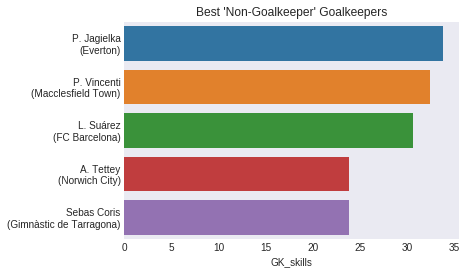

In [31]:
data['GK_skills']=(data['GKDiving']+data['GKHandling']+data['GKKicking']+data['GKPositioning']+data['GKReflexes'])/5
best_gk=data.sort_values('GK_skills',ascending=False).head(5)[['Name','Club','GK_skills']].reset_index(drop=True)

names=best_gk['Name']+['\n(']*best_gk.shape[0]+best_gk['Club']+[')']*best_gk.shape[0]
sns.barplot(y=names,x=best_gk['GK_skills'])
plt.title("Best 'Non-Goalkeeper' Goalkeepers")
plt.show()

Suarez is the third best non-GK goalkeeper! I'm sure Ghanians wouldn't be as surprised as me...

# Thank You!
### Hope You Enjoyed!